In [3]:
import os
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import cv2

label_data =  loadmat("data/labels/imagelabels.mat")
split_data = loadmat("data/labels/setid.mat")

labels = label_data['labels'][0]
train_ids = split_data['trnid'][0]
valid_ids = split_data['valid'][0]
test_ids = split_data['tstid'][0]

print("Total images: ", len(labels))
print("Training images: ", len(train_ids))
print("Validation images: ", len(valid_ids))
print("Testing images: ", len(test_ids))

Total images:  8189
Training images:  1020
Validation images:  1020
Testing images:  6149


In [4]:
IMG_SIZE = 224
IMG_FOLDER = "data/flowers"

def load_and_preprocess_image(img_id):
    filename = f"image_{img_id:05d}.jpg"
    img_path = os.path.join(IMG_FOLDER, filename)

    image = cv2.imread(img_path)
    if image is None:
        return None
    
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    return image.astype(np.float32)


In [5]:
X_train = []
y_train = []

print("Loading training images.....")
for img_id in tqdm(train_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_train.append(img)
        y_train.append(labels[img_id-1])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape:",X_train.shape)
print("y_train shape", y_train.shape)

X_valid =[]
y_valid = []

print("Loading validation images...")
for img_id in tqdm(valid_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_valid.append(img)
        y_valid.append(labels[img_id-1])

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)


print("X_valid shape:",X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_test =[]
y_test = []

print("Loading test images...")
for img_id in tqdm(test_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_test.append(img)
        y_test.append(labels[img_id-1])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:",X_test.shape)
print("y_test shape:", y_test.shape)


Loading training images.....


100%|██████████| 1020/1020 [00:19<00:00, 53.51it/s]


X_train shape: (1020, 224, 224, 3)
y_train shape (1020,)
Loading validation images...


100%|██████████| 1020/1020 [00:18<00:00, 54.83it/s]


X_valid shape: (1020, 224, 224, 3)
y_valid shape: (1020,)
Loading test images...


100%|██████████| 6149/6149 [01:58<00:00, 52.02it/s]


X_test shape: (6149, 224, 224, 3)
y_test shape: (6149,)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()

# string labels into 0-101
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

# one-hot format for CNN model
y_train_cat = to_categorical(y_train_enc)
y_valid_cat = to_categorical(y_valid_enc)
y_test_cat  = to_categorical(y_test_enc)

print("y_train_cat shape:", y_train_cat.shape)

y_train_cat shape: (1020, 102)


In [10]:
# #Simple CNN from Scratch
# from tensorflow.keras.models import Sequential
# from tensorflow.keras .layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential()

# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(102, activation='softmax'))


# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [11]:
# #Data Augmentation
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# datagen.fit(X_train)

# batch_size = 32
# steps_per_epoch = len(X_train) // batch_size  

# import matplotlib.pyplot as plt

# history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=batch_size),
#                     steps_per_epoch=steps_per_epoch,
#                     epochs = 40,
#                     validation_data = (X_valid, y_valid_cat),
#                     verbose = 1)



In [13]:
# model.save("smart_plant_model_v1.h5")


In [14]:
# from tensorflow.keras.models import load_model

# model = load_model("smart_plant_model_v1.h5")

# # Resume training
# history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=32),
#                     steps_per_epoch=len(X_train) // 32,
#                     epochs=20,  # Add more epochs
#                     validation_data=(X_valid, y_valid_cat),
#                     verbose=1)


In [7]:
# Using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#Training the model
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train_cat,batch_size=32),
    validation_data=(X_valid, y_valid_cat),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint('mobilenetv2_best.h5', save_best_only=True)
    ],
    verbose=1
)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 4.6546 - accuracy: 0.0192

d:\Conda\envs\smartplant\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 39s 1s/step - loss: 4.6546 - accuracy: 0.0192 - val_loss: 4.3844 - val_accuracy: 0.0608
Epoch 2/20
31/31 [==============================] - 40s 1s/step - loss: 4.4356 - accuracy: 0.0354 - val_loss: 4.2158 - val_accuracy: 0.1196
Epoch 3/20
31/31 [==============================] - 39s 1s/step - loss: 4.2265 - accuracy: 0.0830 - val_loss: 4.0488 - val_accuracy: 0.1775
Epoch 4/20
31/31 [==============================] - 40s 1s/step - loss: 4.0487 - accuracy: 0.1316 - val_loss: 3.8686 - val_accuracy: 0.2314
Epoch 5/20
31/31 [==============================] - 40s 1s/step - loss: 3.8582 - accuracy: 0.1670 - val_loss: 3.6739 - val_accuracy: 0.2814
Epoch 6/20
31/31 [==============================] - 40s 1s/step - loss: 3.6496 - accuracy: 0.2034 - val_loss: 3.4719 - val_accuracy: 0.3206
Epoch 7/20
31/31 [==============================] - 88s 3s/step - loss: 3.4083 - accuracy: 0.2702 - val_loss: 3.2563 - val_accuracy: 0.3882
Epoch 8/20
31/31 [=============

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
for layer in base_model.layers:  # Unfreezing all layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=5e-7),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=2, 
                                 factor=0.5, 
                                 verbose=1)

# Step 3: Train again
fine_tune_history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_valid, y_valid_cat),
    epochs=10,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint('mobilenetv2_finetuned.h5', save_best_only=True),
        lr_reduction
    ],
    verbose=1
)


Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 3.0471 - accuracy: 0.3067

d:\Conda\envs\smartplant\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 118s 3s/step - loss: 3.0471 - accuracy: 0.3067 - val_loss: 1.4463 - val_accuracy: 0.7118 - lr: 5.0000e-07
Epoch 2/10
31/31 [==============================] - 82s 3s/step - loss: 3.0698 - accuracy: 0.2854 - val_loss: 1.4500 - val_accuracy: 0.7098 - lr: 5.0000e-07
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 3.0465 - accuracy: 0.3026
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
31/31 [==============================] - 79s 3s/step - loss: 3.0465 - accuracy: 0.3026 - val_loss: 1.4565 - val_accuracy: 0.7108 - lr: 5.0000e-07
Epoch 4/10
31/31 [==============================] - 79s 3s/step - loss: 3.0057 - accuracy: 0.3158 - val_loss: 1.4665 - val_accuracy: 0.6980 - lr: 2.5000e-07


In [ ]:
#ensemble feature extraction
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
mobilenet_base.trainable = False  # Freeze base

resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_base.trainable = False  # Freeze base

mobilenet_output = GlobalAveragePooling2D()(mobilenet_base.output)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

merged_features = concatenate([mobilenet_output, resnet_output])

x = Dropout(0.5)(merged_features)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(102, activation='softmax')(x)  # 102 flower classes

fusion_model = Model(inputs=input_tensor, outputs=output_layer)

fusion_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


94765736/94765736 [==============================] - 8s 0us/step


In [ ]:

datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,        
    shear_range=0.2,
    zoom_range=0.2,                
    horizontal_flip=True           
)
datagen.fit(X_train)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('fusion_mobilenet_resnet.h5', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
fusion_history = fusion_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),      
    validation_data=(X_valid, y_valid_cat),                
    epochs=20,                                              
    steps_per_epoch=len(X_train) // 32,                     
    callbacks=[early_stop, checkpoint, lr_scheduler],       
    verbose=1                                               
)


Epoch 1/20
31/31 [==============================] - 132s 4s/step - loss: 4.8425 - accuracy: 0.0162 - val_loss: 4.4434 - val_accuracy: 0.0637 - lr: 1.0000e-04
Epoch 2/20
31/31 [==============================] - 134s 4s/step - loss: 4.6354 - accuracy: 0.0243 - val_loss: 4.3407 - val_accuracy: 0.0922 - lr: 1.0000e-04
Epoch 3/20
31/31 [==============================] - 131s 4s/step - loss: 4.4904 - accuracy: 0.0354 - val_loss: 4.2503 - val_accuracy: 0.1382 - lr: 1.0000e-04
Epoch 4/20
31/31 [==============================] - 113s 4s/step - loss: 4.4461 - accuracy: 0.0435 - val_loss: 4.1617 - val_accuracy: 0.2118 - lr: 1.0000e-04
Epoch 5/20
31/31 [==============================] - 114s 4s/step - loss: 4.3115 - accuracy: 0.0587 - val_loss: 4.0503 - val_accuracy: 0.2402 - lr: 1.0000e-04
Epoch 6/20
31/31 [==============================] - 114s 4s/step - loss: 4.1872 - accuracy: 0.0830 - val_loss: 3.9272 - val_accuracy: 0.2735 - lr: 1.0000e-04
Epoch 7/20
31/31 [==============================] - 

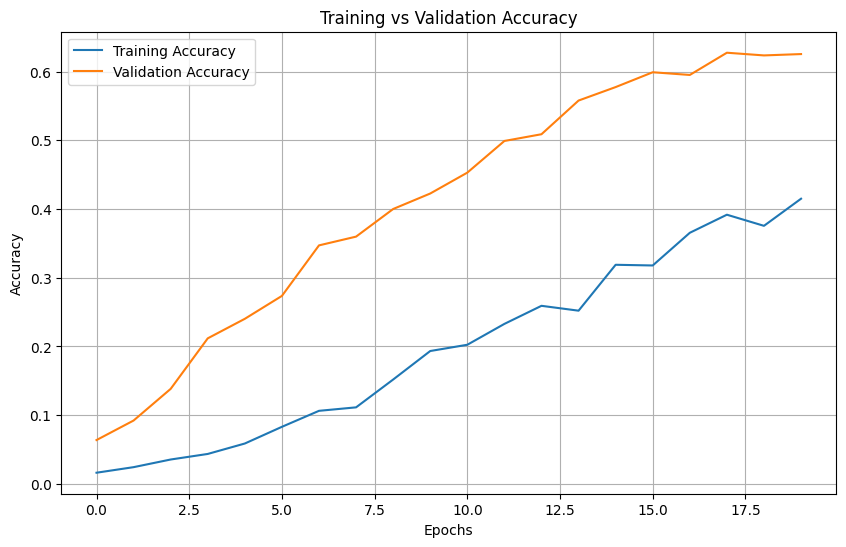

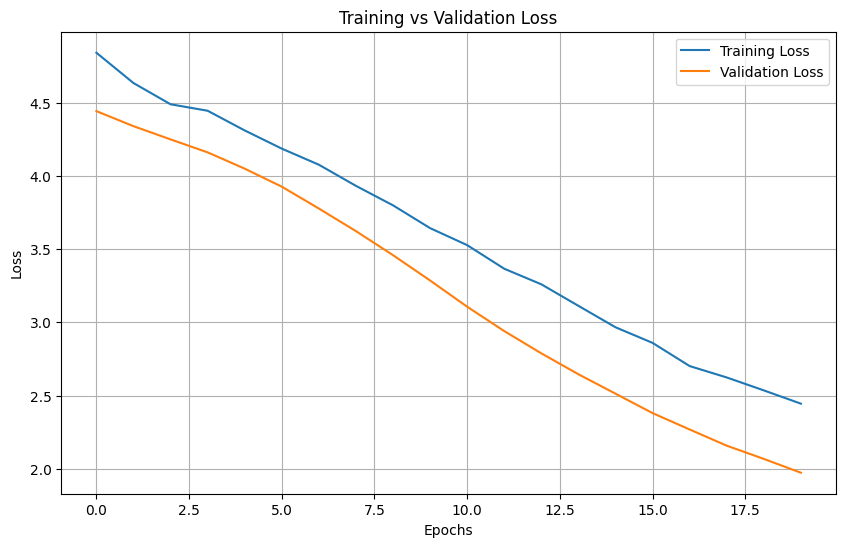

In [18]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(fusion_history.history['accuracy'], label='Training Accuracy')
plt.plot(fusion_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(fusion_history.history['loss'], label='Training Loss')
plt.plot(fusion_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Fine-tuning the Ensemble Feature Extraction Architecture

from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf 

for layer in mobilenet_base.layers[-120:]:
    layer.trainable = True

for layer in resnet_base.layers[-120:]:
    layer.trainable = True

# cosine learning rate scheduler
lr_schedule = CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=100,
    alpha=1e-6
)

# Label smoothing loss
loss = CategoricalCrossentropy(label_smoothing=0.1)

# Compile with learning rate scheduler and Top-5 accuracy
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_ckpt = ModelCheckpoint('ensemble_finetuned.h5', save_best_only=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

fine_tune_history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_valid, y_valid_cat),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[early_stop, model_ckpt, lr_scheduler],
    verbose=1
)


Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.6677 - accuracy: 0.7692 - top_k_categorical_accuracy: 0.9514

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

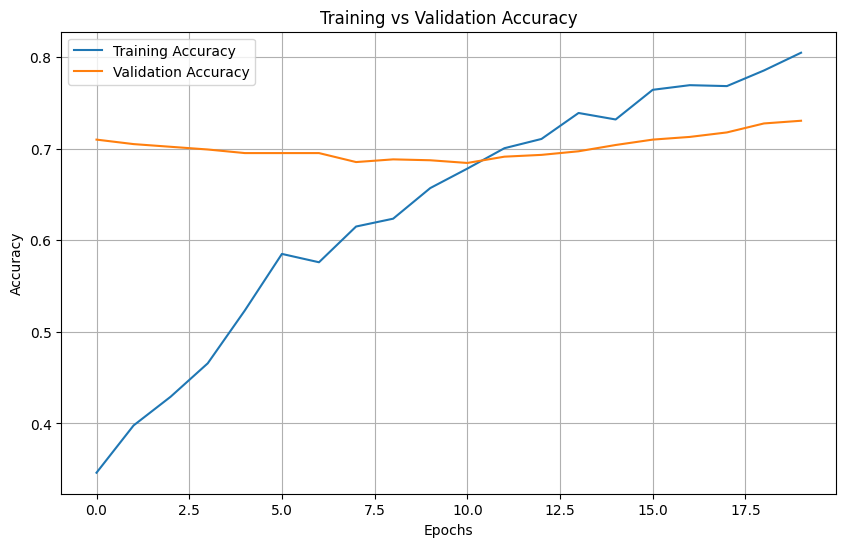

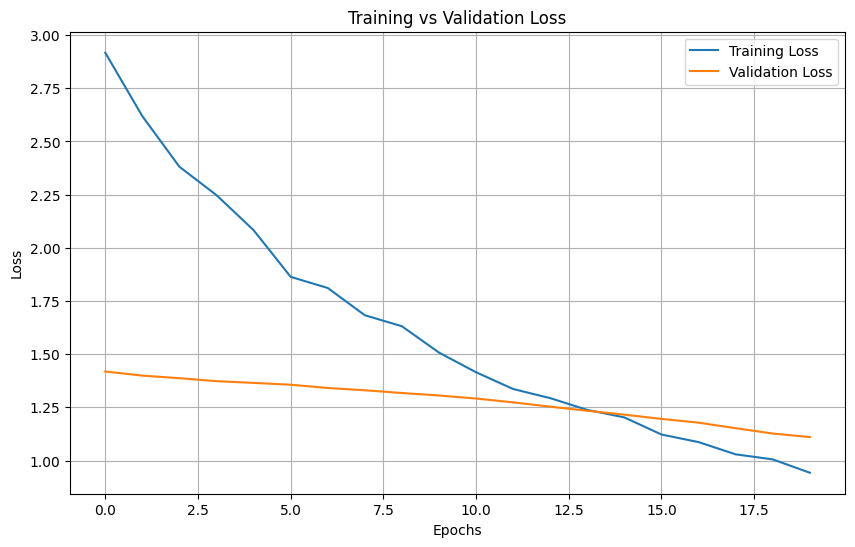

In [17]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = fusion_model.predict(X_test, verbose=1)

y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)  

print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true_classes, y_pred_classes))


193/193 [==============================] - 348s 2s/step
Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.80      0.97      0.88        40
           2       0.12      0.25      0.16        20
           3       0.31      0.33      0.32        36
           4       0.59      0.36      0.44        45
           5       0.69      0.96      0.80        25
           6       0.33      0.95      0.49        20
           7       0.71      0.98      0.83        65
           8       0.59      0.77      0.67        26
           9       0.63      0.88      0.73        25
          10       0.68      0.25      0.37        67
          11       0.89      0.60      0.71        67
          12       0.90      0.90      0.90        29
          13       0.77      0.86      0.81        28
          14       0.56      0.62      0.59        29
          15       0.29      0.90      0.44        21
 